# Commodity prices and Markov chains

#### Written for the QuantEcon Africa Workshop (July 2023)
#### Author: [Shu Hu](https://shu-hu.com/)

In [2]:
!pip install quantecon

In [3]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar, brentq
from scipy.stats import norm, pareto

### Exercise 1 (Commodity prices)

Read the lecture [Commodity Prices](https://intro.quantecon.org/commod_price.html) before you attempt the following exercises.

**Exercise 1.1**

Keep all the other code the same as section [Code](https://intro.quantecon.org/commod_price.html#code), 

except that the shock $Z$ is set to
$$
    Z = a + c \cdot \xi
$$
where $\xi \sim N (0, 1)$.

Compute and plot the approximation of $p^*$ along with the inverse demand curve $P$.

**Solution**

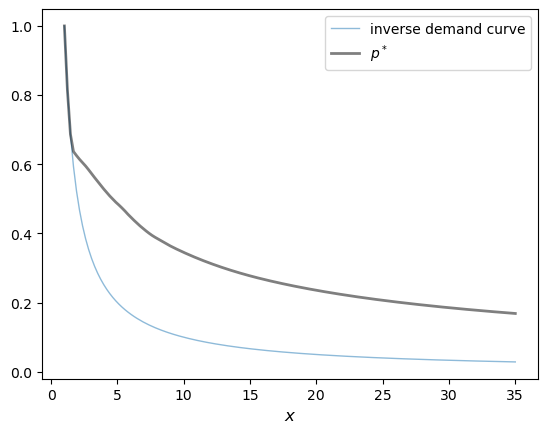

In [4]:
α, a, c = 0.8, 1.0, 2.0
mc_draw_size = 250
gridsize = 150
grid_max = 35
grid = np.linspace(a, grid_max, gridsize)

Z = a + norm.rvs(size=mc_draw_size) * c    # Shock observations
D = P = lambda x: 1.0 / x
tol = 1e-4


def T(p_array):

    new_p = np.empty_like(p_array)

    # Interpolate to obtain p as a function.
    p = interp1d(grid,
                 p_array,
                 fill_value=(p_array[0], p_array[-1]),
                 bounds_error=False)

    # Update
    for i, x in enumerate(grid):

        h = lambda q: q - max(α * np.mean(p(α * (x - D(q)) + Z)), P(x))
        new_p[i] = brentq(h, 1e-8, 100)

    return new_p


fig, ax = plt.subplots()

price = P(grid)
ax.plot(grid, price, alpha=0.5, lw=1, label="inverse demand curve")
error = tol + 1
while error > tol:
    new_price = T(price)
    error = max(np.abs(new_price - price))
    price = new_price

ax.plot(grid, price, 'k-', alpha=0.5, lw=2, label=r'$p^*$')
ax.legend()
ax.set_xlabel('$x$', fontsize=12)

plt.show()

**Exercise 1.2**

Recall that you have learned the lecture [Heavy-Tailed Distributions](https://intro.quantecon.org/heavy_tails.html).

Now do the same job as in Exercise 1.1

except that the shock $Z$ is set to
$$
    Z = a + c \cdot \chi
$$
where $\chi$ follows a Pareto distribution with a tail exponent of $b=1.5$.

**Solution**

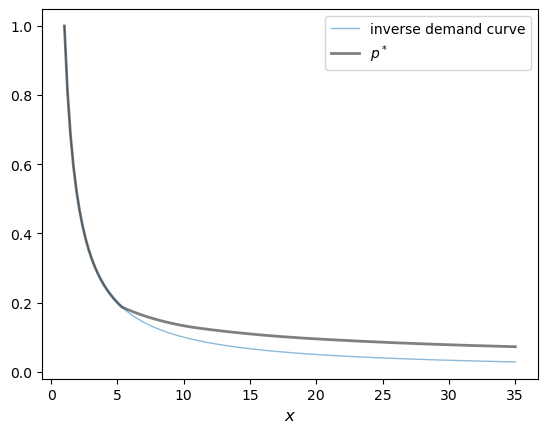

In [5]:
α, a, c = 0.8, 1.0, 2.0
b = 1.5 # set the Pareto tail index
mc_draw_size = 250
gridsize = 150
grid_max = 35
grid = np.linspace(a, grid_max, gridsize)

Z = a + pareto.rvs(b, size=mc_draw_size) * c    # Shock observations
D = P = lambda x: 1.0 / x
tol = 1e-4


def T(p_array):

    new_p = np.empty_like(p_array)

    # Interpolate to obtain p as a function.
    p = interp1d(grid,
                 p_array,
                 fill_value=(p_array[0], p_array[-1]),
                 bounds_error=False)

    # Update
    for i, x in enumerate(grid):

        h = lambda q: q - max(α * np.mean(p(α * (x - D(q)) + Z)), P(x))
        new_p[i] = brentq(h, 1e-8, 100)

    return new_p


fig, ax = plt.subplots()

price = P(grid)
ax.plot(grid, price, alpha=0.5, lw=1, label="inverse demand curve")
error = tol + 1
while error > tol:
    new_price = T(price)
    error = max(np.abs(new_price - price))
    price = new_price

ax.plot(grid, price, 'k-', alpha=0.5, lw=2, label=r'$p^*$')
ax.legend()
ax.set_xlabel('$x$', fontsize=12)

plt.show()

**Exercise 1.3**

Read section [Code](https://intro.quantecon.org/commod_price.html#code).

Using the approximation of $p^*$ from Exercise 1.2

simulate a time series of prices with length $T=100$.

**Solution**

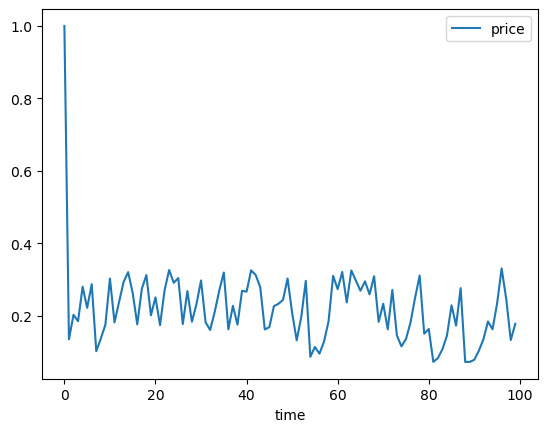

In [6]:
T = 100

# Turn the price array into a price function
p_star = interp1d(grid,
                  price,
                  fill_value=(price[0], price[-1]),
                  bounds_error=False)

def carry_over(x):
    return α * (x - D(p_star(x)))

def generate_cp_ts(init=1, n=T):
    X = np.empty(n)
    X[0] = init
    for t in range(n-1):
            Z = a + c * pareto.rvs(b)
            X[t+1] = carry_over(X[t]) + Z
    return p_star(X)

fig, ax = plt.subplots()
ax.plot(generate_cp_ts(), label="price")
ax.set_xlabel("time")
ax.legend()
plt.show()

### Exercise 2 (Markov chains)

Read the 
- lecture [Markov Chains: Basic Concepts](https://intro.quantecon.org/markov_chains_I.html) and 
- the [corresponding methods in the QuantEcon package](https://quanteconpy.readthedocs.io/en/latest/markov/core.html) 

before you attempt the following exercises.

**Exercise 2.1**

Using a method from the [QuantEcon package](https://quanteconpy.readthedocs.io/en/latest/markov/core.html)

Define a Markov chain object, called ``mc``, characterised by a stochastic matrix ``P`` and state values ``state_values``

In [7]:
P = [[0.1, 0.3, 0.2, 0.4],
     [0.1, 0.4, 0.1, 0.4], 
     [0.3, 0.2, 0.3, 0.2], 
     [0.2, 0.1, 0.2, 0.5]]

state_values = ["recession", "slump", "recovery", "boom"]

**Solution**

In [8]:
T = 5

In [9]:
mc = qe.MarkovChain(P, state_values=state_values)

**Exercise 2.2**

Simulate a Markov chain with length of ``T=5`` using the Markov chain defined from Exercise 2.1 with an initial value ``initial_value``

In [10]:
initial_value = "recession"

**Solution**

In [11]:
mc.simulate(ts_length=T, init=initial_value)

array(['recession', 'boom', 'boom', 'recovery', 'recovery'], dtype='<U9')

**Exercise 2.3**

Calculate the stationary distribution(s), called ``ψ_star``, 

for the Markov chain defined from Exercise 2.1.

**Solution**

In [12]:
ψ_star = mc.stationary_distributions[0]
ψ_star

array([0.17955801, 0.22237569, 0.19751381, 0.40055249])

**Exercise 2.4**

With the Markov chain defined from Exercise 2.1.

Compute the marignal distribution $\psi_t = \psi_0 P^t$ with ``t=100`` and an initial distribution ``ψ_0``

In [13]:
ψ_0 = [0.1, 0.4, 0.3, 0.2]

Compare $\psi_t$ with the ``ψ_star`` from Exercise 2.3.

**Solution**

In [14]:
t = 100
P_power = np.linalg.matrix_power(P, t)
ψ = ψ_0 @ P_power
ψ

array([0.17955801, 0.22237569, 0.19751381, 0.40055249])

Read
- lecture [Markov Chains: Irreducibility and Ergodicity](https://intro.quantecon.org/markov_chains_II.html)


before you attempt the following exercises.

**Exercise 2.5**

With the Markov chain defined from Exercise 2.1.

Check whether its stochastic matrix is irreducible.

**Solution**

In [15]:
mc.is_irreducible

True

**Exercise 2.6**

With the Markov chain defined from Exercise 2.1.

Simulate a path of length ``T = 100_000`` for it and 

Calculate the fraction of time spent on each state values, called ``p_hats`` and

Compare it with the stationary distribution we computed from Exercise 2.3.

**Solution**

In [16]:
T = 100_000
X = mc.simulate(ts_length=T)

In [17]:
p_hats = []
for x0 in state_values:
    p_hat = (X == x0).cumsum() / (1 + np.arange(T, dtype=float))
    p_hats.append(p_hat[-1])

In [18]:
p_hats

[0.17836, 0.22223, 0.19775, 0.40166]

In [19]:
ψ_star

array([0.17955801, 0.22237569, 0.19751381, 0.40055249])